# Deep Learning & Art: Neural Style Transfer
Implement the neural style transfer algorithm to generate novel artistic images

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

#### Transfer Learning

In [2]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

#### Content Cost Function $J_{content}(C,G)$
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

In [3]:
def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = a_G.shape
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.reshape(a_C, shape = [n_H*n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape = [n_H*n_W, n_C])
    
    # compute the cost with tensorflow
    J_content = (1/(4*n_H*n_W*n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content

#### Style Cost Function $J_{style}(S,G)$

In [4]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

In [5]:
def compute_layer_style_cost(a_S, a_G):
    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W)
    a_S = tf.transpose(tf.reshape(a_S, shape = [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape = [n_H * n_W, n_C]))

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = (1/(4*(n_C**2)*(n_H**2)*(n_W**2)))*tf.reduce_sum(tf.square(tf.subtract(GS, GG)))

    return J_style_layer

In [6]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [7]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [8]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

In [9]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

#### Total Cost to Optimize
$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [10]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

#### Load the Content Image

(1, 400, 400, 3)


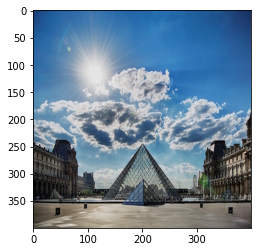

In [11]:
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

#### Load the Style Image

(1, 400, 400, 3)


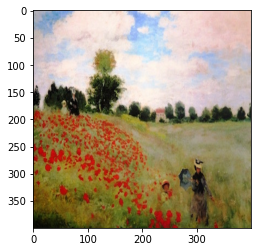

In [12]:
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

#### Random Initialization of Generated Image

(1, 400, 400, 3)


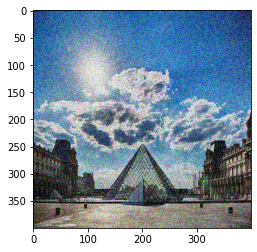

In [13]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

#### Load Pre-trained VGG19 Model

In [14]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [15]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [16]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

#### Compute the Content image Encoding (a_C)

In [17]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

#### Compute the Style image Encoding (a_S)

In [18]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

#### Utils to display the generated images 

In [19]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

#### Train Step

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        
        ### START CODE HERE
        
        #(1 line)
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S, a_G)

        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style, alpha = 10, beta = 40)
        
        ### END CODE HERE
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

#### Train the Model

Epoch 0 


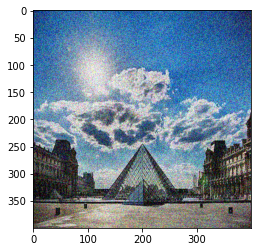

Epoch 1000 


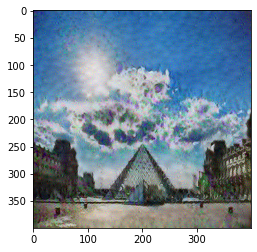

Epoch 2000 


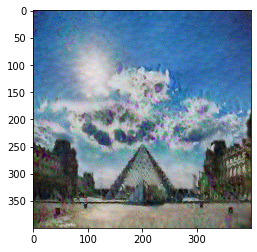

Epoch 3000 


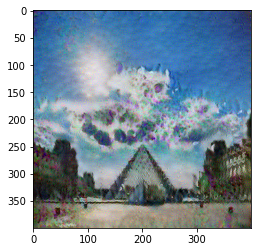

Epoch 4000 


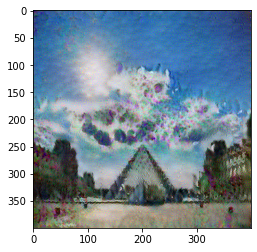

Epoch 5000 


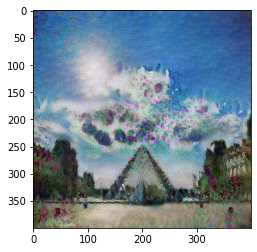

Epoch 6000 


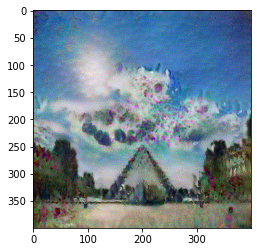

Epoch 7000 


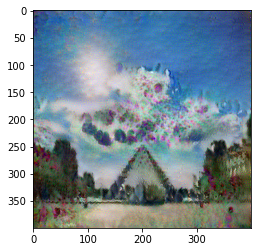

Epoch 8000 


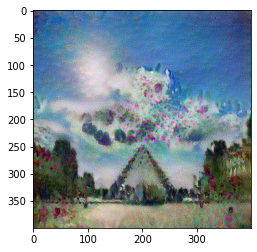

Epoch 9000 


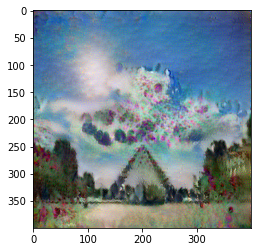

Epoch 10000 


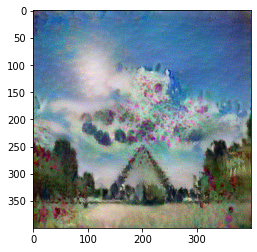

Epoch 11000 


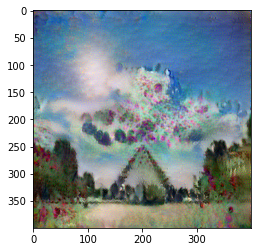

Epoch 12000 


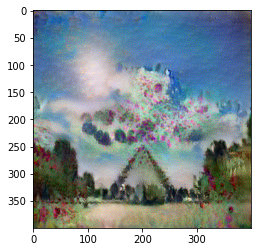

Epoch 13000 


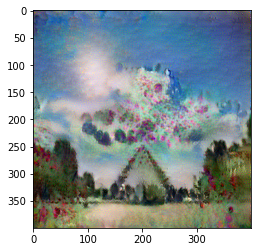

Epoch 14000 


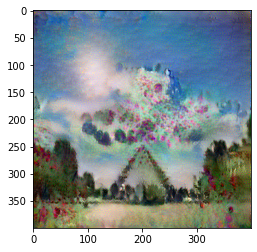

Epoch 15000 


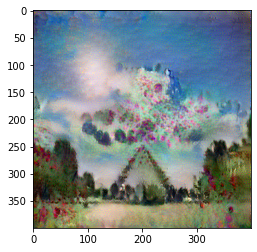

Epoch 16000 


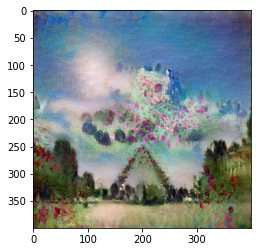

Epoch 17000 


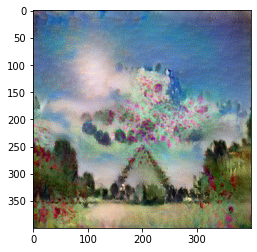

Epoch 18000 


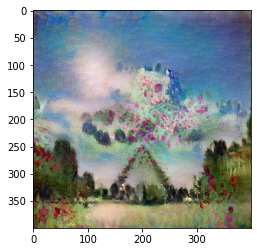

Epoch 19000 


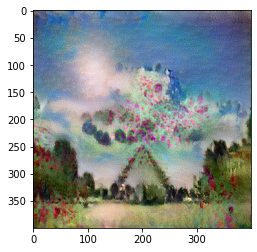

Epoch 20000 


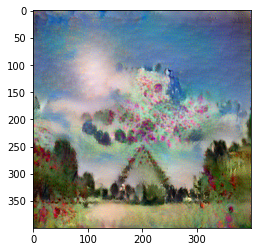

In [21]:
# Show the generated image at some epochs
# Uncoment to reset the style transfer process. You will need to compile the train_step function again 
generated_image = tf.Variable(generated_image)
epochs = 20001
for i in range(epochs):
    train_step(generated_image)
    if i % 1000 == 0:
        print(f"Epoch {i} ")
    if i % 1000 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output2/image_{i}.jpg")
        plt.show() 